In [6]:
import argparse
import json
import os
import time
import itertools
import pickle
import copy
import random
import math

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset


import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config.json

In [7]:
LR_DECAY = False
def get_config():

    # read config json and update the sysarg
    with open("config.json", "r") as read_file:
        config = json.load(read_file)

    if config["config_override"] == "":
        del config['config_override']
    else:
        print(config['config_override'])
        config_override = json.loads(config['config_override'])
        del config['config_override']
        config.update(config_override)

    return config

Class SimpleLinear with simple MLP for MNIST Classification

In [8]:
class SimpleLinear(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, h1)
        self.fc2 = torch.nn.Linear(h1, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        # x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    # def weight(self):
    #     return self.linear1.weight

Class TrainMNISTCluster with all the methods needed to run the experiments

In [9]:
class TrainMNISTCluster(object):
    def __init__(self, config, device):
        self.config = config
        self.device = device

        assert self.config['m'] % self.config['p'] == 0

    def setup(self):

        os.makedirs(self.config['project_dir'], exist_ok = True)

        self.result_fname = os.path.join(self.config['project_dir'], 'results.pickle')
        self.checkpoint_fname = os.path.join(self.config['project_dir'], 'checkpoint.pt')

        self.setup_datasets()
        self.setup_models()

        self.epoch = None
        self.lr = None


    def setup_datasets(self):

        np.random.seed(self.config['data_seed'])

        # generate indices for each dataset
        # also write cluster info

        MNIST_TRAINSET_DATA_SIZE = 60000
        MNIST_TESTSET_DATA_SIZE = 10000

        np.random.seed(self.config['data_seed'])

        cfg = self.config

        self.dataset = {}

        if cfg['uneven'] == True:
            dataset = {}
            dataset['data_indices'], dataset['cluster_assign'] = \
                self._setup_dataset_random_n(MNIST_TRAINSET_DATA_SIZE, cfg['p'], cfg['m'], cfg['n'])
            (X, y) = self._load_MNIST(train=True)
            dataset['X'] = X
            dataset['y'] = y
            self.dataset['train'] = dataset

            dataset = {}
            dataset['data_indices'], dataset['cluster_assign'] = \
                self._setup_dataset_random_n(MNIST_TESTSET_DATA_SIZE, cfg['p'], cfg['m_test'], cfg['n'], random=True)
            (X, y) = self._load_MNIST(train=False)
            dataset['X'] = X
            dataset['y'] = y
            self.dataset['test'] = dataset

        else:
            dataset = {}
            dataset['data_indices'], dataset['cluster_assign'] = \
                self._setup_dataset(MNIST_TRAINSET_DATA_SIZE, cfg['p'], cfg['m'], cfg['n'])
            (X, y) = self._load_MNIST(train=True)
            dataset['X'] = X
            dataset['y'] = y
            self.dataset['train'] = dataset

            dataset = {}
            dataset['data_indices'], dataset['cluster_assign'] = \
                self._setup_dataset(MNIST_TESTSET_DATA_SIZE, cfg['p'], cfg['m_test'], cfg['n'], random=True)
            (X, y) = self._load_MNIST(train=False)
            dataset['X'] = X
            dataset['y'] = y
            self.dataset['test'] = dataset

        # import ipdb; ipdb.set_trace()

    def _setup_dataset(self, num_data, p, m, n, random = True):

        print("m:",m)
        print("p:",p)
        print("n:",n)
        print("num_data:",num_data)
        assert (m // p) * n == num_data

        dataset = {}

        cfg = self.config

        data_indices = []
        cluster_assign = []

        m_per_cluster = m // p

        for p_i in range(p):

            if random:
                ll = list(np.random.permutation(num_data))
            else:
                ll = list(range(num_data))

            ll2 = chunkify(ll, m_per_cluster) # splits ll into m lists with size n
            data_indices += ll2

            cluster_assign += [p_i for _ in range(m_per_cluster)]

        print(type(data_indices))
        data_indices = np.array(data_indices)
        cluster_assign = np.array(cluster_assign)
        assert data_indices.shape[0] == cluster_assign.shape[0]
        assert data_indices.shape[0] == m


        return data_indices, cluster_assign


    def _setup_dataset_random_n(self, num_data, p, m, n, random = True):

        print("m:",m)
        print("p:",p)
        print("num_data:",num_data)

        dataset = {}

        cfg = self.config

        data_indices = []
        cluster_assign = []

        m_per_cluster = m // p

        for p_i in range(p):

            ll = list(np.random.permutation(num_data))

            ll2 = chunkify_uneven(ll, m_per_cluster) # splits ll into m lists
            data_indices += ll2

            cluster_assign += [p_i for _ in range(m_per_cluster)]

        data_indices = np.array(data_indices, dtype=object)
        cluster_assign = np.array(cluster_assign)
        assert data_indices.shape[0] == cluster_assign.shape[0]
        assert data_indices.shape[0] == m


        return data_indices, cluster_assign


    def _load_MNIST(self, train=True):
        transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               # torchvision.transforms.Normalize(
                               #   (0.1307,), (0.3081,))
                             ])
        if train:
            mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
        else:
            mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

        dl = DataLoader(mnist_dataset)

        X = dl.dataset.data # (60000,28, 28)
        y = dl.dataset.targets #(60000)

        # normalize to have 0 ~ 1 range in each pixel

        X = X / 255.0
        X = X.to(self.device)
        y = y.to(self.device)

        return X, y


    # Need p models for each client

    def setup_models(self):
        np.random.seed(self.config['train_seed'])
        torch.manual_seed(self.config['train_seed'])

        p = self.config['p']

        self.models = [ SimpleLinear(h1 = self.config['h1']).to(self.device) for p_i in range(p)] # p models with p different params of dimension(1,d)

        self.criterion = torch.nn.CrossEntropyLoss()

        # import ipdb; ipdb.set_trace()


    def run(self):
        num_epochs = self.config['num_epochs']
        lr = self.config['lr']

        results = []

        # epoch -1
        self.epoch = -1

        result = {}
        result['epoch'] = -1

        t0 = time.time()
        res = self.test(train=True)
        t1 = time.time()
        res['infer_time'] = t1-t0
        result['train'] = res

        self.print_epoch_stats(res)

        t0 = time.time()
        res = self.test(train=False)
        t1 = time.time()
        res['infer_time'] = t1-t0
        result['test'] = res
        self.print_epoch_stats(res)
        results.append(result)

        # this will be used in next epoch
        cluster_assign = result['train']['cluster_assign']

        for epoch in range(num_epochs):
            self.epoch = epoch

            result = {}
            result['epoch'] = epoch

            lr = self.lr_schedule(epoch)
            result['lr'] = lr

            t0 = time.time()
            result['train'] = self.train(cluster_assign, lr = lr)
            t1 = time.time()
            train_time = t1-t0

            t0 = time.time()
            res = self.test(train=True)
            t1 = time.time()
            res['infer_time'] = t1-t0
            res['train_time'] = train_time
            res['lr'] = lr
            result['train'] = res

            self.print_epoch_stats(res)

            t0 = time.time()
            res = self.test(train=False)
            t1 = time.time()
            res['infer_time'] = t1-t0
            result['test'] = res
            self.print_epoch_stats(res)

            results.append(result)

            # this will be used in next epoch's gradient update
            cluster_assign = result['train']['cluster_assign']

            if epoch % 10 == 0 or epoch == num_epochs - 1 :
                with open(self.result_fname, 'wb') as outfile:
                    pickle.dump(results, outfile)
                    print(f'result written at {self.result_fname}')
                self.save_checkpoint()
                print(f'checkpoint written at {self.checkpoint_fname}')

        plt.figure(figsize=(10,5))
        plt.plot([r['train']['loss'] for r in results], label='train')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training Loss per Epoch')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(self.config['project_dir'], 'train_loss.png'))
        # import ipdb; ipdb.set_trace()

        plt.figure(figsize=(10,5))
        plt.plot([r['test']['acc'] for r in results], label='train')
        plt.xlabel('epoch')
        plt.ylabel('test accuracy')
        plt.title('Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(self.config['project_dir'], 'test_acc.png'))

    def lr_schedule(self, epoch):
        if self.lr is None:
            self.lr = self.config['lr']

        if epoch % 50 == 0 and epoch != 0 and LR_DECAY:
            self.lr = self.lr * 0.1

        return self.lr


    def print_epoch_stats(self, res):
        if res['is_train']:
            data_str = 'tr'
        else:
            data_str = 'tst'

        if 'train_time' in res:
            time_str = f"{res['train_time']:.3f}sec(train) {res['infer_time']:.3f}sec(infer)"
        else:
            time_str = f"{res['infer_time']:.3f}sec"

        if 'lr' in res:
            lr_str = f" lr {res['lr']:4f}"
        else:
            lr_str = ""

        str0 = f"Epoch {self.epoch} {data_str}: l {res['loss']:.3f} a {res['acc']:.3f} clct{res['cl_ct']}{lr_str} {time_str}"

        print(str0)

    def train(self, cluster_assign, lr):
        VERBOSE = 0

        cfg = self.config
        m = cfg['m']
        p = cfg['p']
        tau = cfg['tau']

        # run local update
        t0 = time.time()


        updated_models = []
        for m_i in range(m):
            if VERBOSE and m_i % 100 == 0: print(f'm {m_i}/{m} processing \r', end ='')

            (X, y) = self.load_data(m_i)

            p_i = cluster_assign[m_i]
            model = copy.deepcopy(self.models[p_i])

            # LOCAL UPDATE PER MACHINE tau times
            for step_i in range(tau):

                y_logit = model(X)
                loss = self.criterion(y_logit, y)

                model.zero_grad()
                loss.backward()
                self.local_param_update(model, lr)

            model.zero_grad()

            updated_models.append(model)

        t02 = time.time()
        # print(f'running single ..took {t02-t01:.3f}sec')


        t1 = time.time()
        if VERBOSE: print(f'local update {t1-t0:.3f}sec')

        # apply gradient update
        t0 = time.time()

        # CLUSTER MACHINES INTO p_i's
        local_models = [[] for p_i in range(p)]
        for m_i in range(m):
            p_i = cluster_assign[m_i]
            local_models[p_i].append(updated_models[m_i])

        # NEEDS TO BE DECENTRALIZED
        for p_i, models in enumerate(local_models):
            if len(models) > 0:
                # self.dec_param_update(models, self.models[p_i])
                self.global_param_update(models, self.models[p_i])
        t1 = time.time()

        if VERBOSE: print(f'global update {t1-t0:.3f}sec')

    def check_local_model_loss(self, local_models):
        # for debugging
        m = self.config['m']

        losses = []
        for m_i in range(m):
            (X, y) = self.load_data(m_i)
            y_logit = local_models[m_i](X)
            loss = self.criterion(y_logit, y)

            losses.append(loss.item())

        return np.array(losses)


    def get_inference_stats(self, train = True):
        cfg = self.config
        if train:
            m = cfg['m']
            dataset = self.dataset['train']
        else:
            m = cfg['m_test']
            dataset = self.dataset['test']

        p = cfg['p']


        num_data = 0
        losses = {}
        corrects = {}
        for m_i in range(m):
            (X, y) = self.load_data(m_i, train=train) # load batch data rotated

            for p_i in range(p):
                y_logit = self.models[p_i](X)
                loss = self.criterion(y_logit, y) # loss of
                n_correct = self.n_correct(y_logit, y)

                # if torch.isnan(loss):
                #     print("nan loss: ", dataset['data_indices'][m_i])

                losses[(m_i,p_i)] = loss.item()
                corrects[(m_i,p_i)] = n_correct

            num_data += X.shape[0]

        # calculate loss and cluster the machines
        cluster_assign = []
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]
            min_p_i = np.argmin(machine_losses)
            cluster_assign.append(min_p_i)

        # calculate optimal model's loss, acc over all models
        min_corrects = []
        min_losses = []
        for m_i, p_i in enumerate(cluster_assign):

            min_loss = losses[(m_i,p_i)]
            min_losses.append(min_loss)

            min_correct = corrects[(m_i,p_i)]
            min_corrects.append(min_correct)

        # print("losses: ", min_losses)
        loss = np.mean(min_losses)
        acc = np.sum(min_corrects) / num_data


        # check cluster assignment acc
        cl_acc = np.mean(np.array(cluster_assign) == np.array(dataset['cluster_assign']))
        cl_ct = [np.sum(np.array(cluster_assign) == p_i ) for p_i in range(p)]

        res = {} # results
        # res['losses'] = losses
        # res['corrects'] = corrects
        res['cluster_assign'] = cluster_assign
        res['num_data'] = num_data
        res['loss'] = loss
        res['acc'] = acc
        res['cl_acc'] = cl_acc
        res['cl_ct'] = cl_ct
        res['is_train'] = train

        # import ipdb; ipdb.set_trace()

        return res

    def n_correct(self, y_logit, y):
        _, predicted = torch.max(y_logit.data, 1)
        correct = (predicted == y).sum().item()

        return correct

    # TODO Does every Cluster get 4 clients with the same data, but rotated differently?

    def load_data(self, m_i, train=True):
        # this part is very fast since its just rearranging models
        cfg = self.config

        if train:
            dataset = self.dataset['train']
        else:
            dataset = self.dataset['test']

        indices = dataset['data_indices'][m_i]
        p_i = dataset['cluster_assign'][m_i]

        X_batch = dataset['X'][indices]
        y_batch = dataset['y'][indices]

        # k : how many times rotate 90 degree
        # k =1 : 90 , k=2 180, k=3 270

        if cfg['p'] == 4:
            k = p_i
        elif cfg['p'] == 2:
            k = (p_i % 2) * 2
        elif cfg['p'] == 1:
            k = 0
        else:
            raise NotImplementedError("only p=1,2,4 supported")

        X_batch2 = torch.rot90(X_batch, k=int(k), dims = (1,2))
        X_batch3 = X_batch2.reshape(-1, 28 * 28)

        # import ipdb; ipdb.set_trace()

        return X_batch3, y_batch


    def local_param_update(self, model, lr):

        # gradient update manually

        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data -= lr * param.grad

        model.zero_grad()

        # import ipdb; ipdb.set_trace() # we need to check the output of name, check if duplicate exists


    def global_param_update(self, local_models, global_model):

        # average of each weight

        weights = {}

        for m_i, local_model in enumerate(local_models):
            for name, param in local_model.named_parameters():
                if name not in weights:
                    weights[name] = torch.zeros_like(param.data)

                weights[name] += param.data

        for name, param in global_model.named_parameters():
            weights[name] /= len(local_models)
            param.data = weights[name]

        # import ipdb; ipdb.set_trace()


    def dec_param_update(self, local_models, global_model):

        num_clients = len(local_models)

        if num_clients == 0:
            return

        if num_clients == 1:
            bc_client = dict(local_models[0].named_parameters())
            for name, param in global_model.named_parameters():
                param.data = bc_client[name].data.clone()
            return

        max_e = 100
        if num_clients <= max_e:
            e = num_clients - 1
        else:
            e = min(max_e, int(np.log(num_clients) * 10))

        if e >= num_clients:
            e = num_clients - 1

        client_indices = list(range(num_clients))

        for m_i, local_model in enumerate(local_models):
            selected_clients = random.sample([i for i in client_indices if i != m_i], e)

            for m_j in selected_clients:

                m_j_params = dict(local_models[m_j].named_parameters())

                for name, param in local_model.named_parameters():
                    m_i_param = param.data.clone()
                    m_j_param = m_j_params[name].data.clone()
                    param.data = (m_i_param + m_j_param) / 2

        bc_client = random.choice(client_indices)
        bc_client_params = dict(local_models[bc_client].named_parameters())
        for name, param in global_model.named_parameters():
            param.data = bc_client_params[name].data.clone()

        # import ipdb; ipdb.set_trace()


    def test(self, train=False):
        return self.get_inference_stats(train=train)

    def save_checkpoint(self):
        models_to_save = [model.state_dict() for model in self.models]
        torch.save({'models':models_to_save}, self.checkpoint_fname)

Running the Experiment

config: {'m': 1200, 'm_test': 200, 'p': 4, 'n': 200, 'uneven': False, 'h1': 200, 'num_epochs': 3, 'batch_size': 100, 'tau': 10, 'lr': 0.1, 'data_seed': 10, 'train_seed': 10, 'project_dir': 'output'}
Using device: cuda
m: 1200
p: 4
n: 200
num_data: 60000
<class 'list'>
m: 200
p: 4
n: 200
num_data: 10000
<class 'list'>
Epoch -1 tr: l 2.296 a 0.112 clct[369, 321, 143, 367] 1.466sec
Epoch -1 tst: l 2.295 a 0.113 clct[58, 69, 19, 54] 0.249sec
Epoch 0 tr: l 2.171 a 0.415 clct[301, 427, 171, 301] lr 0.100000 5.112sec(train) 1.375sec(infer)
Epoch 0 tst: l 2.168 a 0.417 clct[50, 80, 20, 50] 0.226sec
result written at output\results.pickle
checkpoint written at output\checkpoint.pt
Epoch 1 tr: l 1.910 a 0.652 clct[300, 300, 300, 300] lr 0.100000 4.791sec(train) 1.388sec(infer)
Epoch 1 tst: l 1.901 a 0.656 clct[50, 50, 50, 50] 0.237sec
Epoch 2 tr: l 1.570 a 0.737 clct[300, 300, 300, 300] lr 0.100000 5.759sec(train) 1.534sec(infer)
Epoch 2 tst: l 1.554 a 0.747 clct[50, 50, 50, 50] 0.207sec
result 

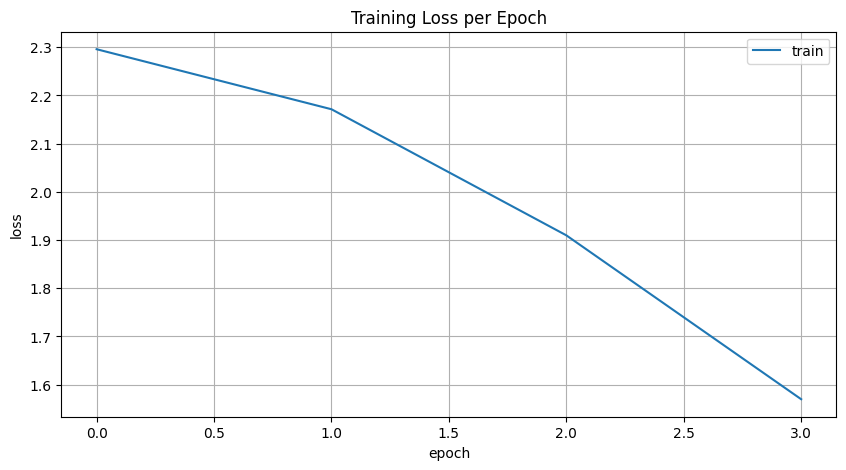

In [10]:
start_time = time.time()
config = get_config()

config['train_seed'] = config['data_seed']

print("config:",config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

exp = TrainMNISTCluster(config, device)
exp.setup()
exp.run()
duration = (time.time() - start_time)
print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))